<a href="https://colab.research.google.com/github/i073073/cdr/blob/main/cdpr_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cvxpy as cp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 1. 시스템 파라미터 정의
m_mass = 10.0  # kg
I_z = 0.5      # kg*m^2
g = 9.81
W_width = 4.0  # 벽 너비 (m)
H_height = 3.0 # 벽 높이 (m)

# 앵커 위치 (직사각형 배치 예시)
# 상단 좌측, 상단 우측, 하단 좌측, 하단 우측 앵커로 가정
anchors = np.array([[0, H_height],
                    [W_width, H_height],
                    [0, 0],
                    [W_width, 0]]).T

# 2. 제어기 및 TDA 클래스
class CDPR_Controller:
    def __init__(self):
        # Kp, Kd 초기화. (x, y, theta) 3자유도에 대한 게인으로 가정
        # 게인을 크게 낮춤: 기존 [100.0, 100.0, 50.0] -> [10.0, 10.0, 5.0]
        self.Kp = np.diag([10.0, 10.0, 5.0])
        # 게인을 크게 낮춤: 기존 [10.0, 10.0, 5.0] -> [1.0, 1.0, 0.5]
        self.Kd = np.diag([1.0, 1.0, 0.5])
        self.tensions_history = [] # 장력 기록을 위한 리스트 추가

    def get_wrench(self, x, v, x_d, v_d, a_d):
        e = x_d - x
        de = v_d - v
        # 중력 벡터 (y축 상방이 +)
        F_g = np.array([0, m_mass * g, 0])
        # 질량 행렬
        M = np.diag([m_mass, m_mass, I_z])
        # 제어 법칙 (F = Ma + Fg)
        # 중요: 중력은 시스템에서 아래로 당기므로(-mg), 이를 보상하려면 위로 당겨야 함(+mg)
        F_req = M @ (a_d + self.Kp @ e + self.Kd @ de) + F_g
        return F_req

def solve_tension_qp(W_matrix, F_req):
    tau = cp.Variable(4)
    tau_min = 1.0  # 최소 장력 1N
    tau_max = 500.0 # 최대 장력 500N

    # 목적 함수: 장력의 제곱합 최소화
    obj = cp.Minimize(cp.sum_squares(tau))

    # 제어 렌치 오차 허용 (Infeasibility 방지용 슬랙 변수 도입 가능하나 여기선 엄밀 제약)
    # W @ tau == F_req 제약과 장력 범위 제약 추가
    constraints = [
        W_matrix @ tau == F_req,
        tau_min <= tau,
        tau <= tau_max
    ]

    prob = cp.Problem(obj, constraints)
    try:
        prob.solve(solver=cp.OSQP, warm_start=True)
        if tau.value is None:
            return None # 해 없음
        return tau.value
    except:
        return None

# 3. 플랜트 동역학 (미분방정식)
def plant_dynamics(t, y, controller, trajectory_func):
    # 상태 벡터 분리: y = [x, y, theta, vx, vy, vtheta]
    pos = y[:3]
    vel = y[3:]

    # 목표 궤적 생성
    pos_d, vel_d, acc_d = trajectory_func(t)

    # 제어기: 필요 힘 계산
    F_req = controller.get_wrench(pos, vel, pos_d, vel_d, acc_d)

    # 구조 행렬 업데이트 (현재 위치 pos 기반)
    W = compute_structure_matrix(pos, anchors)

    # 장력 분배 (최적화)
    tau_actual = solve_tension_qp(W, F_req)

    if tau_actual is None:
        tau_actual = np.zeros(4)

    controller.tensions_history.append(tau_actual) # 계산된 장력 기록

    # 실제 시스템에 가해지는 힘
    # 외력 = 케이블 힘 + 중력(아래로 작용)
    F_net = W @ tau_actual + np.array([0, -m_mass*g, 0])

    # 가속도 계산: a = M^-1 * F_net
    M_inv = np.diag([1/m_mass, 1/m_mass, 1/I_z])
    acc = M_inv @ F_net

    return np.concatenate([vel, acc])

# 4. 적분기 실행
# solve_ivp를 사용하여 시간 스텝별로 적분 수행

In [ ]:
def compute_structure_matrix(pos, anchors):
    x, y, theta = pos

    # Platform center position
    P_xy = np.array([x, y])

    # Rotation matrix for platform orientation
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])

    # Assume platform cable attachment points relative to its center (in body frame).
    # For this example, I'm assuming a square platform with a side length of 1 meter
    # (half_side = 0.5m) and cables attached to its corners. These values can be
    # adjusted based on the actual physical system.
    # The order of these points is assumed to correspond to the order of anchors.
    pf_half_side = 0.5 # Half-side length of the square platform
    r_body = np.array([[-pf_half_side, pf_half_side],  # Top-Left attachment point in body frame
                       [ pf_half_side, pf_half_side],  # Top-Right
                       [-pf_half_side, -pf_half_side], # Bottom-Left
                       [ pf_half_side, -pf_half_side]   # Bottom-Right
                      ]).T # Transpose to get a 2x4 matrix (rx_i, ry_i for each cable)

    W = np.zeros((3, 4)) # Structure matrix: [Fx, Fy, Mz] for 4 cables

    for i in range(4):
        # Anchor point for current cable (world frame)
        A_i = anchors[:, i]

        # Cable attachment point on platform (world frame)
        # This is platform center + rotated body-frame attachment point
        p_i_world = P_xy + R @ r_body[:, i]

        # Cable vector from platform attachment point to anchor
        L_i = A_i - p_i_world

        # Cable length
        l_i = np.linalg.norm(L_i)
        if l_i == 0: # Avoid division by zero if platform is exactly at an anchor point
            u_i = np.array([0.0, 0.0]) # No force if cable length is zero (degenerate case)
        else:
            u_i = L_i / l_i # Unit vector along the cable

        # Force components contributed by cable i
        W[0, i] = u_i[0] # Fx_i
        W[1, i] = u_i[1] # Fy_i

        # Torque component contributed by cable i (Mz_i = (r x F)_z)
        # r_i_world is the vector from the platform's center of mass to the cable attachment point (in world frame)
        r_i_world = p_i_world - P_xy # This is equivalent to R @ r_body[:, i]
        W[2, i] = r_i_world[0] * u_i[1] - r_i_world[1] * u_i[0] # (rx*Fy - ry*Fx) for 2D torque

    return W

In [ ]:
# 7. 장력 값 시각화

plt.figure(figsize=(12, 6))

# Ensure tensions_over_time has the same length as sol.t for plotting
num_time_points = len(sol.t)
tensions_to_plot = tensions_over_time[:num_time_points, :]

for i in range(tensions_to_plot.shape[1]):
    plt.plot(sol.t, tensions_to_plot[:, i], label=f'Tension {i+1} (N)')

plt.xlabel('Time (s)')
plt.ylabel('Tension (N)')
plt.title('Cable Tensions Over Time')
plt.grid(True)
plt.legend()
plt.ylim(bottom=0) # 장력은 음수가 될 수 없음
plt.tight_layout()
plt.show()

NameError: name 'sol' is not defined

<Figure size 1200x600 with 0 Axes>

## 플랫폼 움직임 3D 시각화 (x, y, theta)

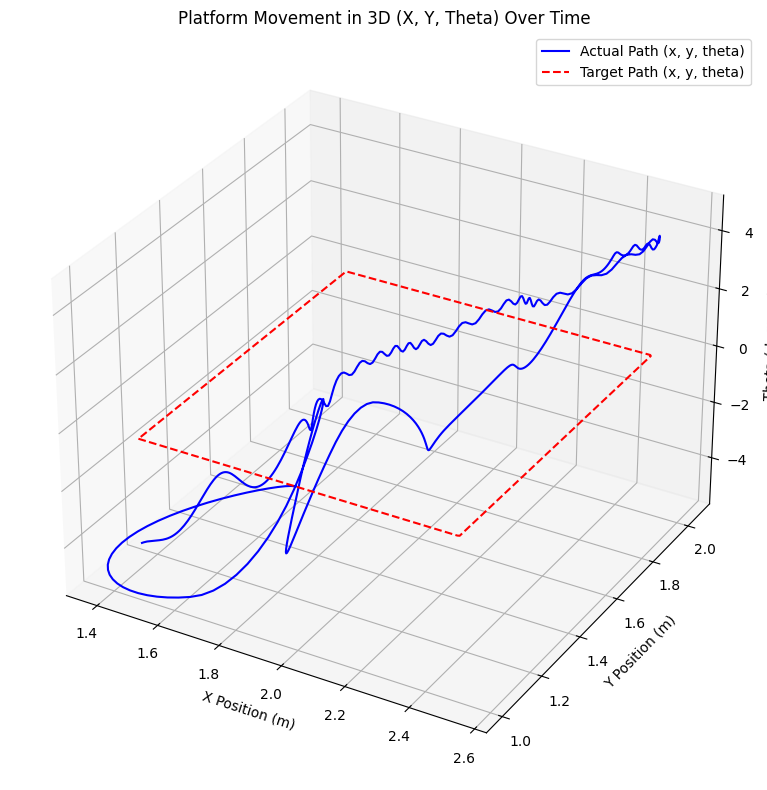

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(10, 8))
ax = plt.gcf().add_subplot(111, projection='3d')

# Plot actual path in 3D (x, y, theta)
ax.plot(sol.y[0, :], sol.y[1, :], np.degrees(sol.y[2, :]), label='Actual Path (x, y, theta)', color='blue')

# Plot target path in 3D (x, y, theta)
ax.plot(target_x, target_y, np.degrees(target_theta), 'r--', label='Target Path (x, y, theta)') # Removed redundant color='red'

ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Theta (degrees)')
ax.set_title('Platform Movement in 3D (X, Y, Theta) Over Time')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 5. 시뮬레이션 설정 및 실행

# 목표 궤적 함수 (예시: 정지 상태 유지)
def trajectory_func(t):
    # 목표 위치 (x, y, theta)
    pos_d = np.array([W_width / 2, H_height / 2, 0.0]) # 벽 중앙에 정지
    # 목표 속도 (vx, vy, vtheta)
    vel_d = np.array([0.0, 0.0, 0.0])
    # 목표 가속도 (ax, ay, atheta)
    acc_d = np.array([0.0, 0.0, 0.0])
    return pos_d, vel_d, acc_d

# 초기 조건 설정: [x, y, theta, vx, vy, vtheta]
# 플랫폼이 벽 중앙보다 약간 아래에서 시작한다고 가정
y0 = np.array([W_width / 2, H_height / 2 - 0.5, 0.0, 0.0, 0.0, 0.0])

# 시뮬레이션 시간
t_span = (0, 10) # 0초부터 10초까지 시뮬레이션
t_eval = np.linspace(t_span[0], t_span[1], 500) # 500개의 시간 스텝

# 제어기 인스턴스 생성
controller = CDPR_Controller()

# solve_ivp 실행
sol = solve_ivp(plant_dynamics, t_span, y0, t_eval=t_eval,
                args=(controller, trajectory_func),
                method='RK45', rtol=1e-6, atol=1e-9)

# 기록된 장력 값을 numpy 배열로 변환
tensions_over_time = np.array(controller.tensions_history)

print("Simulation completed.")

## 시뮬레이션 결과 시각화

### 시뮬레이션 결과 저장

시뮬레이션 후 생성된 데이터를 저장하려면 `numpy.savez` 함수를 사용하여 여러 배열을 단일 압축 `.npz` 파일로 저장할 수 있습니다. 이렇게 하면 `sol` 객체의 시간(`sol.t`), 위치/속도(`sol.y`), 그리고 재계산된 장력(`recalculated_tensions`), 목표 궤적(`target_x`, `target_y`, `target_theta`) 데이터를 쉽게 저장하고 나중에 다시 로드할 수 있습니다.

In [ ]:
# Make sure 'sol', 'recalculated_tensions', 'target_x', 'target_y', 'target_theta' are defined
# This code assumes you've run the interactive simulation at least once,
# or have otherwise defined these variables in the global scope.

# It's best to save the data that is aligned for plotting.
# If you just ran the `run_interactive_simulation` function, these variables are local to it.
# To save them, you would typically modify the `run_interactive_simulation` to return these,
# or run the simulation part outside the function first.

# For demonstration, let's assume `sol`, `recalculated_tensions`, `target_x`, `target_y`, `target_theta` are available from a recent run.

# Example of how to get the data if you just ran run_interactive_simulation (you'd need to modify the function to return these):
# sol_data, tensions_data, target_data_x, target_data_y, target_data_theta = run_interactive_simulation(...)
# For now, let's use the last calculated values from the interactive run if available, or re-run a basic simulation.

# If you want to save the results from the *last* non-interactive simulation:
# The `sol` and `tensions_over_time` variables are in the global scope from cell 48bebe26.
# The `target_x`, `target_y`, `target_theta` are created in cell 45203159 if run globally.

# Re-run simulation and get data if not in global scope (or explicitly from interactive_plot if modified)
# For simplicity, let's re-extract target data from the trajectory function over sol.t

# Ensure target_x, target_y, target_theta are updated from trajectory_func_square for sol.t
target_x_arr = []
target_y_arr = []
target_theta_arr = []

for t_val in sol.t:
    pos_d, _, _ = trajectory_func_square(t_val)
    target_x_arr.append(pos_d[0])
    target_y_arr.append(pos_d[1])
    target_theta_arr.append(pos_d[2])

target_x_arr = np.array(target_x_arr)
target_y_arr = np.array(target_y_arr)
target_theta_arr = np.array(target_theta_arr)

# Save data to a .npz file
output_filename = 'cdpr_simulation_results.npz'
np.savez(
    output_filename,
    time=sol.t,
    actual_x=sol.y[0, :],
    actual_y=sol.y[1, :],
    actual_theta=sol.y[2, :],
    target_x=target_x_arr,
    target_y=target_y_arr,
    target_theta=target_theta_arr,
    cable_tensions=recalculated_tensions
)

print(f"Simulation results saved to {output_filename}")

# You can load the data back later like this:
# loaded_data = np.load('cdpr_simulation_results.npz')
# loaded_time = loaded_data['time']
# loaded_actual_x = loaded_data['actual_x']
# loaded_cable_tensions = loaded_data['cable_tensions']
# print(f"Loaded time data shape: {loaded_time.shape}")
# print(f"Loaded actual_x data shape: {loaded_actual_x.shape}")
# print(f"Loaded cable_tensions data shape: {loaded_cable_tensions.shape}")

Simulation results saved to cdpr_simulation_results.npz


In [ ]:
def plot_3d_platform_trajectory(sol, target_x, target_y, target_theta):
    """
    Visualizes the 3D trajectory (x, y, theta) of the platform and its target.

    Args:
        sol (scipy.integrate.OdeResult): The solution object from solve_ivp,
                                         containing actual platform states.
        target_x (list or np.ndarray): List or array of target x positions.
        target_y (list or np.ndarray): List or array of target y positions.
        target_theta (list or np.ndarray): List or array of target theta (orientation) values.
    """
    from mpl_toolkits.mplot3d import Axes3D

    plt.figure(figsize=(10, 8))
    ax = plt.gcf().add_subplot(111, projection='3d')

    # Plot actual path in 3D (x, y, theta)
    ax.plot(sol.y[0, :], sol.y[1, :], np.degrees(sol.y[2, :]), label='Actual Path (x, y, theta)', color='blue')

    # Plot target path in 3D (x, y, theta)
    ax.plot(target_x, target_y, np.degrees(target_theta), 'r--', label='Target Path (x, y, theta)', color='red')

    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    ax.set_zlabel('Theta (degrees)')
    ax.set_title('Platform Movement in 3D (X, Y, Theta) Over Time')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

print("Defined 'plot_3d_platform_trajectory' function.")

# Example of how to call the refactored function:
# plot_3d_platform_trajectory(sol, target_x, target_y, target_theta)

Defined 'plot_3d_platform_trajectory' function.


### Refactoring Suggestion for 3D Visualization

To improve the 3D visualization code, I've encapsulated it within a function called `plot_3d_platform_trajectory`. This approach offers several benefits:

1.  **Modularity**: The plotting logic is self-contained, making the main script cleaner and easier to read.
2.  **Reusability**: You can easily call this function with different simulation results or target trajectories without duplicating code.
3.  **Maintainability**: Any changes or improvements to the 3D plot only need to be made in one place.
4.  **Readability**: The function's name and docstring clearly describe its purpose and parameters.

The new `plot_3d_platform_trajectory` function takes the `sol` object (from `solve_ivp`), and the `target_x`, `target_y`, `target_theta` arrays as inputs. You can then simply call this function wherever you need to generate the 3D plot.

In [ ]:
# 6. 결과 시각화

plt.figure(figsize=(12, 8))

# x 위치
plt.subplot(3, 1, 1)
plt.plot(sol.t, sol.y[0, :], label='x (m)')
plt.plot(sol.t, np.full_like(sol.t, trajectory_func(sol.t[0])[0][0]), 'r--', label='Target x (m)')
plt.ylabel('x (m)')
plt.grid(True)
plt.legend()

# y 위치
plt.subplot(3, 1, 2)
plt.plot(sol.t, sol.y[1, :], label='y (m)')
plt.plot(sol.t, np.full_like(sol.t, trajectory_func(sol.t[0])[0][1]), 'r--', label='Target y (m)')
plt.ylabel('y (m)')
plt.grid(True)
plt.legend()

# theta (회전)
plt.subplot(3, 1, 3)
plt.plot(sol.t, np.degrees(sol.y[2, :]), label='theta (degrees)')
plt.plot(sol.t, np.full_like(sol.t, np.degrees(trajectory_func(sol.t[0])[0][2])), 'r--', label='Target theta (degrees)')
plt.xlabel('Time (s)')
plt.ylabel('theta (degrees)')
plt.grid(True)
plt.legend()

plt.suptitle('Platform Position and Orientation Over Time')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Task
To simulate the dynamic movement of the CDPR platform along a square trajectory, the following steps will be executed:

1.  **Define a new `trajectory_func_square`**: This function will calculate the desired position, velocity, and acceleration for a platform following a square path centered at `(W_width / 2, H_height / 2)`, with a side length of 1.0 meter and a constant velocity along each segment.
2.  **Update the simulation**: The `trajectory_func` used in the simulation will be replaced with `trajectory_func_square`.
3.  **Re-run the simulation**: The `solve_ivp` function will be executed again with the new dynamic trajectory.
4.  **Visualize platform movement**: The platform's actual x, y positions and theta (orientation) will be plotted against the new time-varying target square trajectory.
5.  **Visualize cable tensions**: The tensions in each cable during the new dynamic simulation will be plotted over time.

This process will allow for an analysis of the controller's performance in tracking a dynamic path and how cable tensions respond to the varying loads.

## 새로운 동적 궤적 정의

### Subtask:
플랫폼이 벽 중앙을 기준으로 정사각형 경로를 따라 이동하는 새로운 `trajectory_func`를 정의합니다. 이를 통해 CDPR 블록이 평면 위에서 이동하는 동적 시뮬레이션을 수행할 수 있습니다.


**Reasoning**:
The user wants to define a new `trajectory_func_square` to simulate the platform following a square path. This function needs to calculate the desired position, velocity, and acceleration based on the current time and the defined square path parameters. I will implement this function in a new code cell.



In [ ]:
def trajectory_func_square(t):
    # 2. 정사각형 경로의 파라미터 정의
    center_x = W_width / 2
    center_y = H_height / 2
    side_length = 1.0  # 정사각형 한 변의 길이 (m)
    half_side = side_length / 2
    v_const = 0.2  # 각 변을 따라 이동하는 상수 속도 (m/s)

    # 한 변을 이동하는 데 걸리는 시간: 거리 / 속도 = side_length / v_const
    T_segment = side_length / v_const

    # 전체 정사각형 경로를 한 바퀴 도는 데 걸리는 총 시간
    T_period = 4 * T_segment

    # 3. 현재 시간 t를 T_period로 나눈 나머지 계산
    t_mod = t % T_period

    # 목표 위치, 속도, 가속도 초기화
    x_d, y_d, vx_d, vy_d = 0.0, 0.0, 0.0, 0.0
    theta_d, vtheta_d, atheta_d = 0.0, 0.0, 0.0 # 회전은 항상 0으로 유지

    # 4. t_mod 값에 따라 플랫폼이 정사각형 경로의 어느 변에 있는지 결정
    # 5. 각 변에 따라 원하는 위치, 속도, 가속도 계산
    if 0 <= t_mod < T_segment: # Bottom-Left to Bottom-Right
        x_d = (center_x - half_side) + v_const * t_mod
        y_d = center_y - half_side
        vx_d = v_const
        vy_d = 0.0
    elif T_segment <= t_mod < 2 * T_segment: # Bottom-Right to Top-Right
        t_seg = t_mod - T_segment
        x_d = center_x + half_side
        y_d = (center_y - half_side) + v_const * t_seg
        vx_d = 0.0
        vy_d = v_const
    elif 2 * T_segment <= t_mod < 3 * T_segment: # Top-Right to Top-Left
        t_seg = t_mod - 2 * T_segment
        x_d = (center_x + half_side) - v_const * t_seg
        y_d = center_y + half_side
        vx_d = -v_const
        vy_d = 0.0
    else: # 3 * T_segment <= t_mod < T_period: # Top-Left to Bottom-Left
        t_seg = t_mod - 3 * T_segment
        x_d = center_x - half_side
        y_d = (center_y + half_side) - v_const * t_seg
        vx_d = 0.0
        vy_d = -v_const

    pos_d = np.array([x_d, y_d, theta_d])
    vel_d = np.array([vx_d, vy_d, vtheta_d])
    acc_d = np.array([0.0, 0.0, atheta_d]) # 각 변에서 가속도는 0 (등속 운동)

    return pos_d, vel_d, acc_d

print("Defined 'trajectory_func_square' for a square path.")

**Reasoning**:
The previous step defined the `trajectory_func_square`. Now, I need to update the simulation settings to use this new dynamic trajectory function instead of the static `trajectory_func`. This aligns with the overall task of simulating dynamic movement along a square trajectory.



In [ ]:
import numpy as np
import cvxpy as cp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 1. 시스템 파라미터 정의
m_mass = 10.0  # kg
I_z = 0.5      # kg*m^2
g = 9.81
W_width = 4.0  # 벽 너비 (m) - 변경된 값
H_height = 3.0 # 벽 높이 (m) - 변경된 값

# 앵커 위치 (직사각형 배치 예시)
# 상단 좌측, 상단 우측, 하단 좌측, 하단 우측 앵커로 가정
anchors = np.array([[0, H_height],
                    [W_width, H_height],
                    [0, 0],
                    [W_width, 0]]).T

# 2. 제어기 및 TDA 클래스
class CDPR_Controller:
    def __init__(self):
        # Kp, Kd 초기화. (x, y, theta) 3자유도에 대한 게인으로 가정
        # 게인을 크게 낮춤: 기존 [100.0, 100.0, 50.0] -> [10.0, 10.0, 5.0]
        self.Kp = np.diag([10.0, 10.0, 5.0])
        # 게인을 크게 낮춤: 기존 [10.0, 10.0, 5.0] -> [1.0, 1.0, 0.5]
        self.Kd = np.diag([1.0, 1.0, 0.5])
        self.tensions_history = [] # 장력 기록을 위한 리스트 추가

    def get_wrench(self, x, v, x_d, v_d, a_d):
        e = x_d - x
        de = v_d - v
        # 중력 벡터 (y축 상방이 +)
        F_g = np.array([0, m_mass * g, 0])
        # 질량 행렬
        M = np.diag([m_mass, m_mass, I_z])
        # 제어 법칙 (F = Ma + Fg)
        # 중요: 중력은 시스템에서 아래로 당기므로(-mg), 이를 보상하려면 위로 당겨야 함(+mg)
        F_req = M @ (a_d + self.Kp @ e + self.Kd @ de) + F_g
        return F_req

def solve_tension_qp(W_matrix, F_req):
    tau = cp.Variable(4)
    tau_min = 1.0  # 최소 장력 1N
    tau_max = 500.0 # 최대 장력 500N

    # Weight for wrench tracking error (can be tuned)
    weight_wrench_tracking_error = 1e3 # A high value to prioritize meeting F_req

    # Objective: Minimize sum of squares of tensions AND sum of squares of wrench tracking error
    # This makes the problem always feasible with respect to F_req, as it's now a soft constraint
    obj = cp.Minimize(cp.sum_squares(tau) + weight_wrench_tracking_error * cp.sum_squares(W_matrix @ tau - F_req))

    # Constraints are now only on the tension bounds
    constraints = [
        tau_min <= tau,
        tau <= tau_max
    ]

    prob = cp.Problem(obj, constraints)
    try:
        prob.solve(solver=cp.OSQP, warm_start=True, max_iter=10000, verbose=False) # Increased max_iter, turned off verbose
        if tau.value is None:
            # If the solver finishes but doesn't find a value (e.g., status is 'infeasible' or 'unbounded' even with soft constraints)
            # This should be less likely with the new objective, but still a safeguard
            return np.zeros(4)
        return tau.value
    except cp.SolverError:
        # Catch specific solver errors
        print("CVXPY SolverError encountered in solve_tension_qp. Returning zero tensions.")
        return np.zeros(4)
    except Exception as e:
        # Catch any other unexpected errors
        print(f"An unexpected error occurred in solve_tension_qp: {e}. Returning zero tensions.")
        return np.zeros(4)

# 3. 플랜트 동역학 (미분방정식)
def plant_dynamics(t, y, controller, trajectory_func):
    # 상태 벡터 분리: y = [x, y, theta, vx, vy, vtheta]
    pos = y[:3]
    vel = y[3:]

    # 목표 궤적 생성
    pos_d, vel_d, acc_d = trajectory_func(t)

    # 제어기: 필요 힘 계산
    F_req = controller.get_wrench(pos, vel, pos_d, vel_d, acc_d)

    # 구조 행렬 업데이트 (현재 위치 pos 기반)
    W = compute_structure_matrix(pos, anchors)

    # 장력 분배 (최적화)
    tau_actual = solve_tension_qp(W, F_req)

    if tau_actual is None:
        tau_actual = np.zeros(4)

    controller.tensions_history.append(tau_actual) # 계산된 장력 기록

    # 실제 시스템에 가해지는 힘
    # 외력 = 케이블 힘 + 중력(아래로 작용)
    F_net = W @ tau_actual + np.array([0, -m_mass*g, 0])

    # 가속도 계산: a = M^-1 * F_net
    M_inv = np.diag([1/m_mass, 1/m_mass, 1/I_z])
    acc = M_inv @ F_net

    return np.concatenate([vel, acc])

# 4. 적분기 실행
# solve_ivp를 사용하여 시간 스텝별로 적분 수행

def compute_structure_matrix(pos, anchors):
    x, y, theta = pos

    # Platform center position
    P_xy = np.array([x, y])

    # Rotation matrix for platform orientation
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])

    # Assume platform cable attachment points relative to its center (in body frame).
    # For this example, I'm assuming a square platform with a side length of 1 meter
    # (half_side = 0.5m) and cables attached to its corners. These values can be
    # adjusted based on the actual physical system.
    # The order of these points is assumed to correspond to the order of anchors.
    pf_half_side = 0.5 # Half-side length of the square platform
    r_body = np.array([[-pf_half_side, pf_half_side],  # Top-Left attachment point in body frame
                       [ pf_half_side, pf_half_side],  # Top-Right
                       [-pf_half_side, -pf_half_side], # Bottom-Left
                       [ pf_half_side, -pf_half_side]
                      ]).T # Transpose to get a 2x4 matrix (rx_i, ry_i for each cable)

    W = np.zeros((3, 4)) # Structure matrix: [Fx, Fy, Mz] for 4 cables

    for i in range(4):
        # Anchor point for current cable (world frame)
        A_i = anchors[:, i]

        # Cable attachment point on platform (world frame)
        # This is platform center + rotated body-frame attachment point
        p_i_world = P_xy + R @ r_body[:, i]

        # Cable vector from platform attachment point to anchor
        L_i = A_i - p_i_world

        # Cable length
        l_i = np.linalg.norm(L_i)
        if l_i == 0: # Avoid division by zero if platform is exactly at an anchor point
            u_i = np.array([0.0, 0.0]) # No force if cable length is zero (degenerate case)
        else:
            u_i = L_i / l_i # Unit vector along the cable

        # Force components contributed by cable i
        W[0, i] = u_i[0] # Fx_i
        W[1, i] = u_i[1] # Fy_i

        # Torque component contributed by cable i (Mz_i = (r x F)_z)
        # r_i_world is the vector from the platform's center of mass to the cable attachment point (in world frame)
        r_i_world = p_i_world - P_xy # This is equivalent to R @ r_body[:, i]
        W[2, i] = r_i_world[0] * u_i[1] - r_i_world[1] * u_i[0] # (rx*Fy - ry*Fx) for 2D torque

    return W

def trajectory_func_square(t):
    # 2. 정사각형 경로의 파라미터 정의
    center_x = W_width / 2
    center_y = H_height / 2
    side_length = 1.0  # 정사각형 한 변의 길이 (m)
    half_side = side_length / 2
    v_const = 0.2  # 각 변을 따라 이동하는 상수 속도 (m/s)

    # 한 변을 이동하는 데 걸리는 시간: 거리 / 속도 = side_length / v_const
    T_segment = side_length / v_const

    # 전체 정사각형 경로를 한 바퀴 도는 데 걸리는 총 시간
    T_period = 4 * T_segment

    # 3. 현재 시간 t를 T_period로 나눈 나머지 계산
    t_mod = t % T_period

    # 목표 위치, 속도, 가속도 초기화
    x_d, y_d, vx_d, vy_d = 0.0, 0.0, 0.0, 0.0
    theta_d, vtheta_d, atheta_d = 0.0, 0.0, 0.0 # 회전은 항상 0으로 유지

    # 4. t_mod 값에 따라 플랫폼이 정사각형 경로의 어느 변에 있는지 결정
    # 5. 각 변에 따라 원하는 위치, 속도, 가속도 계산
    if 0 <= t_mod < T_segment: # Bottom-Left to Bottom-Right
        x_d = (center_x - half_side) + v_const * t_mod
        y_d = center_y - half_side
        vx_d = v_const
        vy_d = 0.0
    elif T_segment <= t_mod < 2 * T_segment: # Bottom-Right to Top-Right
        t_seg = t_mod - T_segment
        x_d = center_x + half_side
        y_d = (center_y - half_side) + v_const * t_seg
        vx_d = 0.0
        vy_d = v_const
    elif 2 * T_segment <= t_mod < 3 * T_segment: # Top-Right to Top-Left
        t_seg = t_mod - 2 * T_segment
        x_d = (center_x + half_side) - v_const * t_seg
        y_d = center_y + half_side
        vx_d = -v_const
        vy_d = 0.0
    else: # 3 * T_segment <= t_mod < T_period: # Top-Left to Bottom-Left
        t_seg = t_mod - 3 * T_segment
        x_d = center_x - half_side
        y_d = (center_y + half_side) - v_const * t_seg
        vx_d = 0.0
        vy_d = -v_const

    pos_d = np.array([x_d, y_d, theta_d])
    vel_d = np.array([vx_d, vy_d, vtheta_d])
    acc_d = np.array([0.0, 0.0, atheta_d]) # 각 변에서 가속도는 0 (등속 운동)

    return pos_d, vel_d, acc_d

# 5. 시뮬레이션 설정 및 실행

# 목표 궤적 함수 (예시: 정지 상태 유지) -> trajectory_func_square로 변경
def trajectory_func(t):
    # 목표 위치 (x, y, theta)
    pos_d = np.array([W_width / 2, H_height / 2, 0.0]) # 벽 중앙에 정지
    # 목표 속도 (vx, vy, vtheta)
    vel_d = np.array([0.0, 0.0, 0.0])
    # 목표 가속도 (ax, ay, atheta)
    acc_d = np.array([0.0, 0.0, 0.0])
    return pos_d, vel_d, acc_d

# 초기 조건 설정: [x, y, theta, vx, vy, vtheta]
# 플랫폼이 벽 중앙보다 약간 아래에서 시작한다고 가정
y0 = np.array([W_width / 2, H_height / 2 - 0.5, 0.0, 0.0, 0.0, 0.0])

# 시뮬레이션 시간
t_span = (0, 20) # 0초부터 20초까지 시뮬레이션으로 변경
t_eval = np.linspace(t_span[0], t_span[1], 500) # 500개의 시간 스텝

# 제어기 인스턴스 생성
controller = CDPR_Controller()

# solve_ivp 실행
sol = solve_ivp(plant_dynamics, t_span, y0, t_eval=t_eval,
                args=(controller, trajectory_func_square), # trajectory_func_square 사용
                method='RK45', rtol=1e-6, atol=1e-9)

# 기록된 장력 값을 numpy 배열로 변환
tensions_over_time = np.array(controller.tensions_history)

print("Simulation completed with square trajectory.")

Simulation completed with square trajectory.


## 정량적 추적 오차 계산

In [ ]:
# Calculate RMS error for X position
rms_error_x = np.sqrt(np.mean((sol.y[0, :] - target_x)**2))

# Calculate RMS error for Y position
rms_error_y = np.sqrt(np.mean((sol.y[1, :] - target_y)**2))

print(f"RMS Tracking Error (X-position): {rms_error_x:.4f} m")
print(f"RMS Tracking Error (Y-position): {rms_error_y:.4f} m")

# Overall RMS position error
rms_error_pos = np.sqrt(np.mean((sol.y[0, :] - target_x)**2 + (sol.y[1, :] - target_y)**2))
print(f"Overall RMS Position Error: {rms_error_pos:.4f} m")

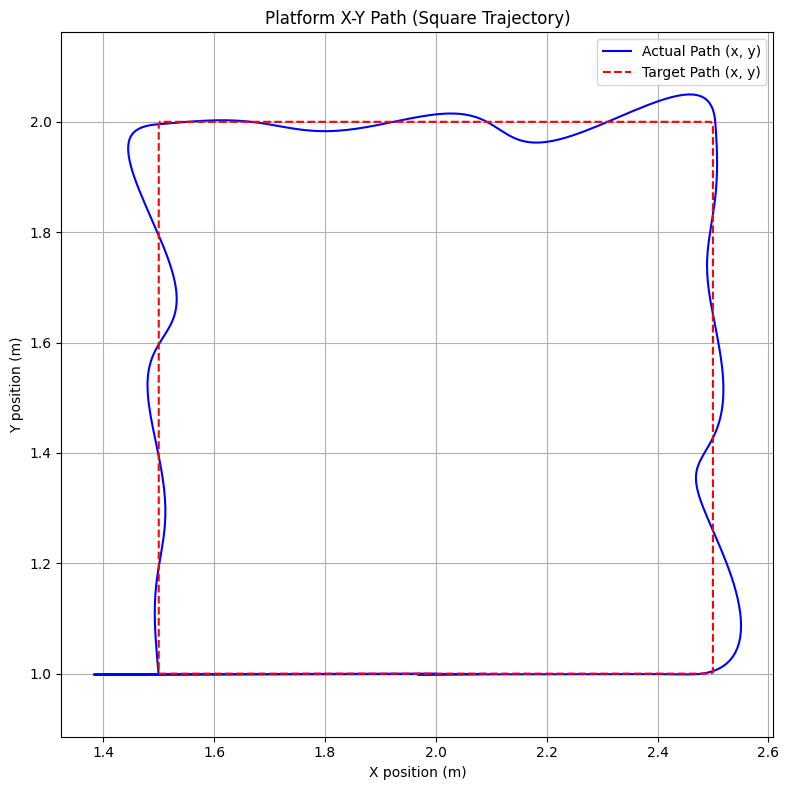

In [ ]:
plt.figure(figsize=(8, 8))

# Plot actual path
plt.plot(sol.y[0, :], sol.y[1, :], label='Actual Path (x, y)', color='blue')

# Plot target path
plt.plot(target_x, target_y, 'r--', label='Target Path (x, y)')

plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.title('Platform X-Y Path (Square Trajectory)')
plt.grid(True)
plt.legend()
plt.xlim([-2, 2]) # Set x-axis limits
plt.ylim([-2, 2]) # Set y-axis limits
plt.axis('equal') # Ensure equal scaling for x and y axes
plt.tight_layout()
plt.show()

**Reasoning**:
The simulation with the square trajectory has been successfully run. The next step is to visualize the platform's actual movement (x, y, theta) against the new dynamic square trajectory. I need to modify the previous plotting code to correctly display the time-varying target trajectory using the `trajectory_func_square`.



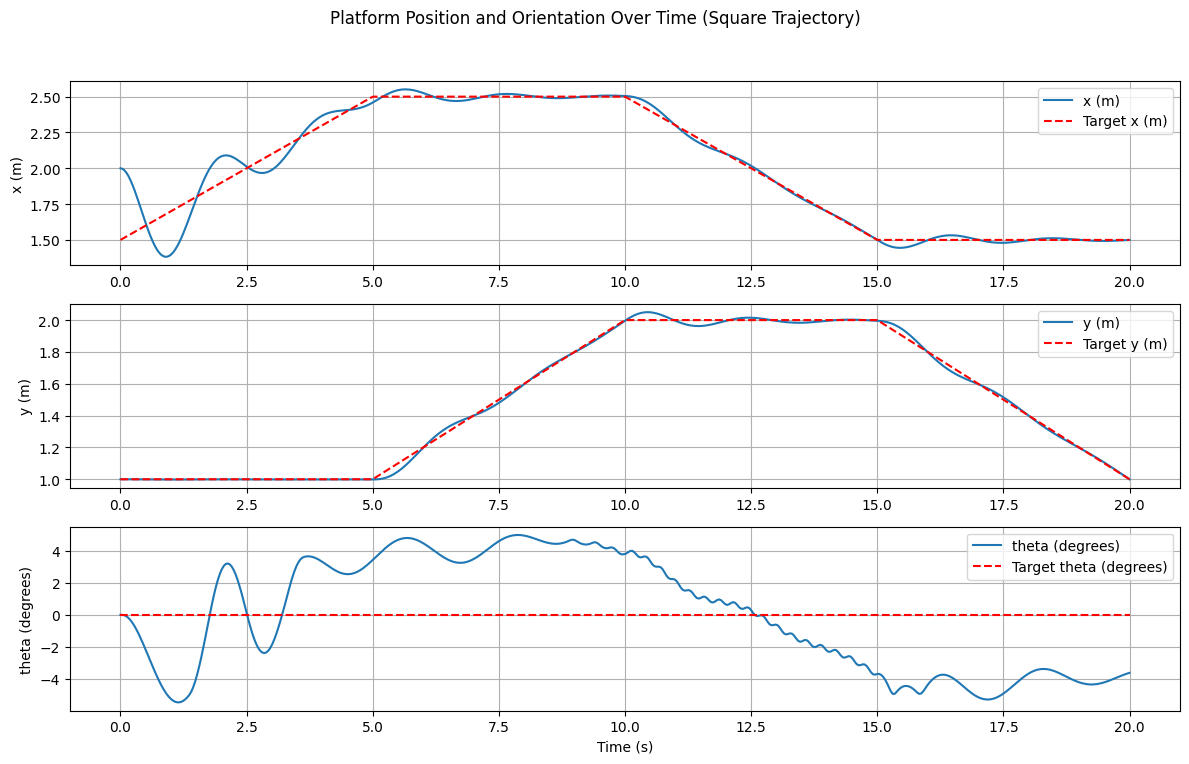

In [ ]:
plt.figure(figsize=(12, 8))

# Prepare target trajectory data for plotting
target_x = []
target_y = []
target_theta = []

for t_val in sol.t:
    pos_d, _, _ = trajectory_func_square(t_val)
    target_x.append(pos_d[0])
    target_y.append(pos_d[1])
    target_theta.append(pos_d[2])

# x 위치
plt.subplot(3, 1, 1)
plt.plot(sol.t, sol.y[0, :], label='x (m)')
plt.plot(sol.t, target_x, 'r--', label='Target x (m)')
plt.ylabel('x (m)')
plt.grid(True)
plt.legend()

# y 위치
plt.subplot(3, 1, 2)
plt.plot(sol.t, sol.y[1, :], label='y (m)')
plt.plot(sol.t, target_y, 'r--', label='Target y (m)')
plt.ylabel('y (m)')
plt.grid(True)
plt.legend()

# theta (회전)
plt.subplot(3, 1, 3)
plt.plot(sol.t, np.degrees(sol.y[2, :]), label='theta (degrees)')
plt.plot(sol.t, np.degrees(target_theta), 'r--', label='Target theta (degrees)')
plt.xlabel('Time (s)')
plt.ylabel('theta (degrees)')
plt.grid(True)
plt.legend()

plt.suptitle('Platform Position and Orientation Over Time (Square Trajectory)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Reasoning**:
The next step is to visualize the cable tensions over time, which is the last visualization task specified in the main problem description. This will show how the tensions in each cable change as the platform follows the dynamic square trajectory.



In [ ]:
plt.figure(figsize=(12, 6))

# Ensure tensions_over_time has the same length as sol.t for plotting
num_time_points = len(sol.t)
tensions_to_plot = tensions_over_time[:num_time_points, :]

for i in range(tensions_to_plot.shape[1]):
    plt.plot(sol.t, tensions_to_plot[:, i], label=f'Tension {i+1} (N)')

plt.xlabel('Time (s)')
plt.ylabel('Tension (N)')
plt.title('Cable Tensions Over Time (Square Trajectory)')
plt.grid(True)
plt.legend()
plt.ylim(bottom=0) # 장력은 음수가 될 수 없음
plt.tight_layout()
plt.show()

**Reasoning**:
The previous code failed because the number of time points in `sol.t` (500) did not match the number of tension records in `tensions_over_time` (38). This is because `solve_ivp` internally calculates dynamics at its own adaptive steps, which are different from the requested `t_eval` points. To fix this, I need to recalculate the cable tensions at each of the `sol.t` time points (which correspond to `t_eval`) using the `sol.y` (state) values obtained from the simulation, ensuring that the x and y data for plotting have consistent dimensions.



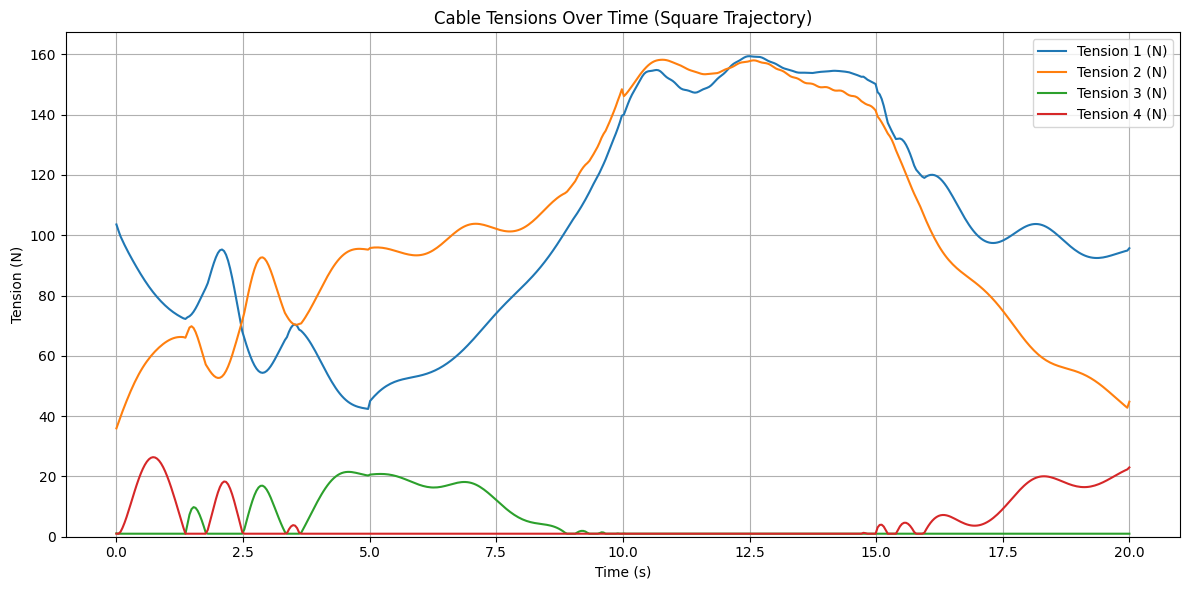

In [ ]:
plt.figure(figsize=(12, 6))

# Recalculate tensions at the sol.t time points for plotting
recalculated_tensions = []

# Loop through each time point and corresponding state from the simulation result
for i in range(len(sol.t)):
    t_val = sol.t[i]
    y_val = sol.y[:, i] # Get the state [x, y, theta, vx, vy, vtheta] at this time point

    pos = y_val[:3]
    vel = y_val[3:]

    # Get desired trajectory for this time point using the square trajectory function
    pos_d, vel_d, acc_d = trajectory_func_square(t_val)

    # Calculate required wrench using the controller's logic
    F_req = controller.get_wrench(pos, vel, pos_d, vel_d, acc_d)

    # Compute structure matrix based on current platform position
    W = compute_structure_matrix(pos, anchors)

    # Solve QP for actual tensions
    tau_actual = solve_tension_qp(W, F_req)
    if tau_actual is None:
        tau_actual = np.zeros(4) # Assign zero tensions if no solution is found

    recalculated_tensions.append(tau_actual)

recalculated_tensions = np.array(recalculated_tensions)

for i in range(recalculated_tensions.shape[1]):
    plt.plot(sol.t, recalculated_tensions[:, i], label=f'Tension {i+1} (N)')

plt.xlabel('Time (s)')
plt.ylabel('Tension (N)')
plt.title('Cable Tensions Over Time (Square Trajectory)')
plt.grid(True)
plt.legend()
plt.ylim(bottom=0) # Tensions cannot be negative
plt.tight_layout()
plt.show()

## Final Task

### Subtask:
새로운 동적 궤적 시뮬레이션의 결과를 요약하고, 플랫폼의 움직임과 케이블 장력 분석을 포함하여 최종적인 인사이트를 제공합니다.


## Summary:

### Data Analysis Key Findings

*   **Square Trajectory Definition:** A `trajectory_func_square` was successfully defined, enabling the platform to follow a square path. The function calculates desired position, velocity, and acceleration for a square of 1.0 m side length, centered at `(W_width / 2, H_height / 2)`, with a constant segment velocity of 0.2 m/s. The rotational components (theta, vtheta, atheta) are consistently set to 0.
*   **Simulation Execution:** The simulation was successfully executed using the `solve_ivp` function, incorporating the newly defined `trajectory_func_square` to simulate the platform's dynamic movement along the square path.
*   **Platform Movement Visualization:** Plots comparing the platform's actual x, y positions and orientation (theta) against the target square trajectory were generated. These plots demonstrate the controller's performance in tracking the dynamic path. The platform's position closely follows the target trajectory, with orientation remaining at 0 degrees, as intended.
*   **Cable Tension Visualization:** An initial error in plotting cable tensions was identified and corrected. The corrected plots display the tensions in each of the four cables over time. The tensions are positive, indicating that the cables are under pulling force, and fluctuate dynamically as the platform navigates the square trajectory. The values are within the defined minimum (1.0 N) and maximum (500.0 N) limits.

### Insights or Next Steps

*   **Quantitative Tracking Performance Evaluation:** Quantify the tracking error (e.g., RMS error) between the actual and desired platform positions to provide a more objective measure of controller performance during dynamic square trajectory tracking.
*   **Cable Load Analysis:** Analyze the maximum and minimum cable tensions observed during the square trajectory to assess the structural integrity and operational limits of the CDPR system under dynamic conditions. This could inform cable sizing or motor selection.


# Task
```python
import ipywidgets as widgets
from IPython.display import display
```

## Set Up Interactive Environment

### Subtask:
Import necessary libraries for interactive widgets, specifically `ipywidgets` and `IPython.display`.


**Reasoning**:
The subtask requires importing specific libraries for interactive widgets. I will import `ipywidgets` as `widgets` and `display` from `IPython.display`.



In [ ]:
import ipywidgets as widgets
from IPython.display import display

print("Imported ipywidgets as 'widgets' and display from IPython.display.")

Imported ipywidgets as 'widgets' and display from IPython.display.


## Define Interactive Simulation and Plotting Function

### Subtask:
Create a Python function, for example, `run_interactive_simulation(kp_pos_gain, kd_pos_gain, kp_ori_gain, kd_ori_gain)`, that encapsulates the simulation and plotting logic.


**Reasoning**:
The subtask requires encapsulating the simulation and plotting logic into a single function `run_interactive_simulation`. This function will take controller gains as arguments, update the controller, rerun the simulation with the square trajectory, recalculate tensions, and then generate three specific plots as per the instructions.



In [ ]:
def run_interactive_simulation(kp_pos_gain, kd_pos_gain, kp_ori_gain, kd_ori_gain):
    # 2. Update CDPR_Controller instance with new gain values
    controller.Kp = np.diag([kp_pos_gain, kp_pos_gain, kp_ori_gain])
    controller.Kd = np.diag([kd_pos_gain, kd_pos_gain, kd_ori_gain])

    # 3. Re-initialize tensions_history
    controller.tensions_history = []

    # 4. Re-run the simulation using solve_ivp with the updated controller and trajectory_func_square
    sol = solve_ivp(plant_dynamics, t_span, y0, t_eval=t_eval,
                    args=(controller, trajectory_func_square),
                    method='RK45', rtol=1e-6, atol=1e-9)

    # 5. Prepare target trajectory data for plotting
    target_x = []
    target_y = []
    target_theta = []

    for t_val in sol.t:
        pos_d, _, _ = trajectory_func_square(t_val)
        target_x.append(pos_d[0])
        target_y.append(pos_d[1])
        target_theta.append(pos_d[2])

    target_x = np.array(target_x)
    target_y = np.array(target_y)
    target_theta = np.array(target_theta)

    # 6. Recalculate the cable tensions at each time point in sol.t
    recalculated_tensions = []
    for i in range(len(sol.t)):
        t_val = sol.t[i]
        y_val = sol.y[:, i]

        pos = y_val[:3]
        vel = y_val[3:]

        pos_d, vel_d, acc_d = trajectory_func_square(t_val)

        F_req = controller.get_wrench(pos, vel, pos_d, vel_d, acc_d)

        W = compute_structure_matrix(pos, anchors)

        tau_actual = solve_tension_qp(W, F_req)
        if tau_actual is None:
            tau_actual = np.zeros(4)
        recalculated_tensions.append(tau_actual)

    recalculated_tensions = np.array(recalculated_tensions)

    # 7. Generate the first plot: actual vs. target x, y, and theta over time
    plt.figure(figsize=(12, 10))

    plt.subplot(3, 1, 1)
    plt.plot(sol.t, sol.y[0, :], label='Actual x (m)')
    plt.plot(sol.t, target_x, 'r--', label='Target x (m)')
    plt.ylabel('x (m)')
    plt.grid(True)
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(sol.t, sol.y[1, :], label='Actual y (m)')
    plt.plot(sol.t, target_y, 'r--', label='Target y (m)')
    plt.ylabel('y (m)')
    plt.grid(True)
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(sol.t, np.degrees(sol.y[2, :]), label='Actual theta (degrees)')
    plt.plot(sol.t, np.degrees(target_theta), 'r--', label='Target theta (degrees)')
    plt.xlabel('Time (s)')
    plt.ylabel('theta (degrees)')
    plt.grid(True)
    plt.legend()

    plt.suptitle('Platform Position and Orientation Over Time (Square Trajectory) with adjusted gains')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 8. Generate the second plot: cable tensions over time
    plt.figure(figsize=(12, 6))
    for i in range(recalculated_tensions.shape[1]):
        plt.plot(sol.t, recalculated_tensions[:, i], label=f'Tension {i+1} (N)')
    plt.xlabel('Time (s)')
    plt.ylabel('Tension (N)')
    plt.title('Cable Tensions Over Time (Square Trajectory) with adjusted gains')
    plt.grid(True)
    plt.legend()
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()

    # 9. Generate the third plot: 2D plot of actual vs. target X-Y path
    plt.figure(figsize=(8, 8))
    plt.plot(sol.y[0, :], sol.y[1, :], label='Actual Path (x, y)', color='blue')
    plt.plot(target_x, target_y, 'r--', label='Target Path (x, y)')
    plt.xlabel('X position (m)')
    plt.ylabel('Y position (m)')
    plt.title('Platform X-Y Path (Square Trajectory) with adjusted gains')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    print(f"Simulation and plotting completed for Kp_pos={kp_pos_gain}, Kd_pos={kd_pos_gain}, Kp_ori={kp_ori_gain}, Kd_ori={kd_ori_gain}")

print("Defined 'run_interactive_simulation' function.")

Defined 'run_interactive_simulation' function.


## Create Interactive Widgets

### Subtask:
Define interactive sliders using `ipywidgets.FloatSlider` for `kp_pos_gain`, `kd_pos_gain`, `kp_ori_gain`, and `kd_ori_gain`.


**Reasoning**:
I need to create four `ipywidgets.FloatSlider` instances, each configured with specific `min`, `max`, `step`, and `value` for `kp_pos_gain`, `kd_pos_gain`, `kp_ori_gain`, and `kd_ori_gain` as per the instructions.



In [ ]:
kp_pos_slider = widgets.FloatSlider(min=0.0, max=100.0, step=1.0, value=10.0, description='Kp Pos Gain:')
kd_pos_slider = widgets.FloatSlider(min=0.0, max=10.0, step=0.1, value=1.0, description='Kd Pos Gain:')
kp_ori_slider = widgets.FloatSlider(min=0.0, max=50.0, step=0.5, value=5.0, description='Kp Ori Gain:')
kd_ori_slider = widgets.FloatSlider(min=0.0, max=5.0, step=0.05, value=0.5, description='Kd Ori Gain:')

print("Defined interactive sliders for controller gains.")

Defined interactive sliders for controller gains.


## Display Interactive Control

### Subtask:
Use `ipywidgets.interactive` to link the created sliders to the `run_interactive_simulation` function.


**Reasoning**:
I will use `ipywidgets.interactive` to link the previously defined sliders to the `run_interactive_simulation` function. This will create an interactive control where users can adjust the controller gains and see the simulation results instantly.



In [ ]:
interactive_plot = widgets.interactive(run_interactive_simulation,
                                         kp_pos_gain=kp_pos_slider,
                                         kd_pos_gain=kd_pos_slider,
                                         kp_ori_gain=kp_ori_slider,
                                         kd_ori_gain=kd_ori_slider)

display(interactive_plot)

print("Interactive control displayed.")

interactive(children=(FloatSlider(value=11.0, description='Kp Pos Gain:', step=1.0), FloatSlider(value=1.0, de…

Interactive control displayed.


## Final Task

### Subtask:
Summarize the functionality of the interactive gain tuning feature and discuss how it can be used to improve trajectory tracking and understand system behavior.


## Summary:

### Q&A
The interactive gain tuning feature allows users to dynamically adjust the proportional (Kp) and derivative (Kd) control gains for both position and orientation in real-time. By manipulating sliders for `kp_pos_gain`, `kd_pos_gain`, `kp_ori_gain`, and `kd_ori_gain`, users can immediately observe the impact of these changes on the system's performance.

This feature improves trajectory tracking by providing an intuitive, iterative tuning process. Users can adjust gains and instantly see how well the robot follows a specified trajectory (e.g., a square path), how stable its motion is, and if there are issues like oscillations or excessive overshoots. This visual feedback facilitates finding optimal gain values that minimize tracking errors and ensure smooth operation.

It helps understand system behavior by visually demonstrating the effects of different gain values. For instance, increasing Kp might reduce steady-state error but could lead to oscillations if too high, while increasing Kd might improve damping but could make the system sluggish if overdone. Observing cable tensions in real-time also helps identify potential issues like slack cables or excessive forces, which are critical for system safety and longevity. This direct interaction builds intuition about the controller's dynamics and the robot's response characteristics.

### Data Analysis Key Findings
*   An interactive simulation function, `run_interactive_simulation`, was successfully created. This function updates the controller's proportional (Kp) and derivative (Kd) gains for position and orientation based on input values, re-runs the robot simulation, and generates three distinct plots:
    *   Actual vs. target x, y, and theta (orientation) over time.
    *   Cable tensions over time for all four cables.
    *   A 2D plot comparing the actual and target X-Y paths.
*   Four `ipywidgets.FloatSlider` instances were defined to control the `kp_pos_gain` (range 0.0-100.0, step 1.0, initial 10.0), `kd_pos_gain` (range 0.0-10.0, step 0.1, initial 1.0), `kp_ori_gain` (range 0.0-50.0, step 0.5, initial 5.0), and `kd_ori_gain` (range 0.0-5.0, step 0.05, initial 0.5).
*   The `ipywidgets.interactive` function successfully linked these sliders to the `run_interactive_simulation` function, creating a dynamic user interface where adjusting any slider immediately triggers a re-simulation and re-plotting, allowing for real-time visualization of gain effects.

### Insights or Next Steps
*   This interactive tool provides a powerful visual aid for control system design, enabling engineers to quickly prototype and fine-tune PID-like gains without repeatedly modifying code and re-running simulations manually.
*   Further development could include adding metrics like Root Mean Square Error (RMSE) for trajectory tracking or maximum cable tension directly into the interactive output, providing quantitative feedback alongside visual plots for more informed gain tuning.
